# Data integrity analysis
In this notebook we study if there is some missing (or redundant) value in the time series extracted from the Internet. It has been executed before finishing ESIOS etl(), and it's been useful to understand missing and incorrect data. If you execute it now, results will differ.

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import isoparse
from datetime import timedelta

from sktime.utils.plotting import plot_series

from etl.esios.provider import ESIOSDataProvider

In [22]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


## ESIOS time series

In [189]:
start_date = isoparse("2014-01-01T00:00+00:00")
end_date = isoparse("2023-02-28T23:00+00:00")

date_range_esios = pd.date_range(start_date, end_date, freq="H")
print(len(date_range_esios))

80304


In [179]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(len(esios_tickers))
print(esios_tickers)

10
['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA_TERRESTRE', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_DERIVADOS_DEL_PETRÓLEO_Ó_CARBÓN', 'GENERACIÓN_MEDIDA_GAS_NATURAL_COGENERACIÓN', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR_FOTOVOLTAICA', 'PRECIO_MERCADO_SPOT_DIARIO']


Plot all the time series

/Users/pedrobedmar/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

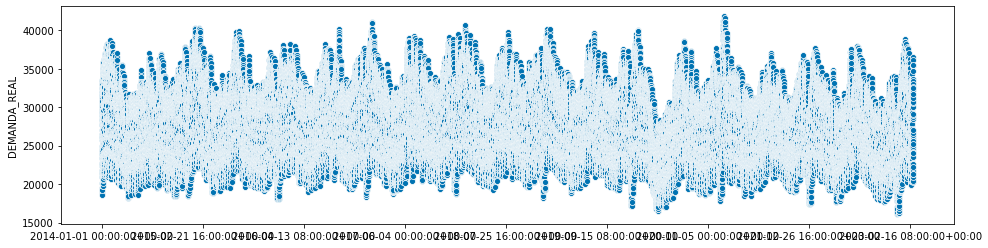

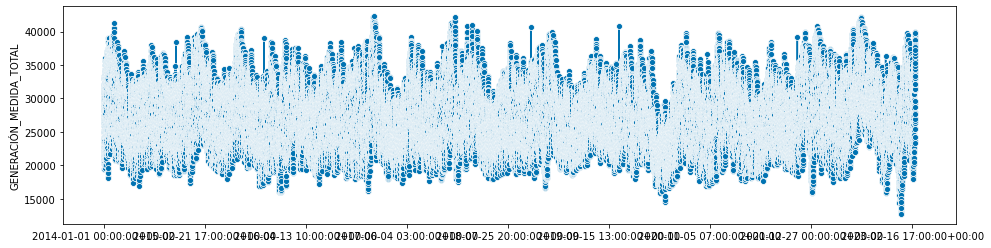

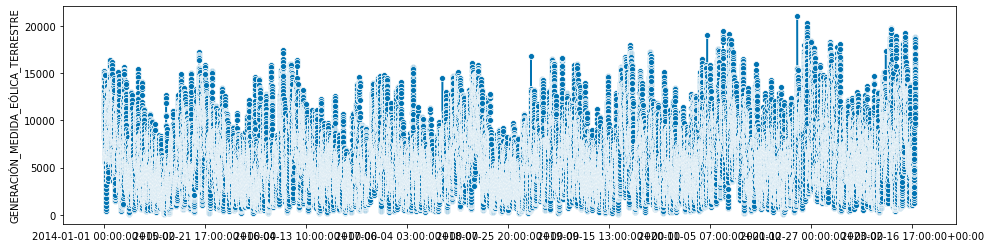

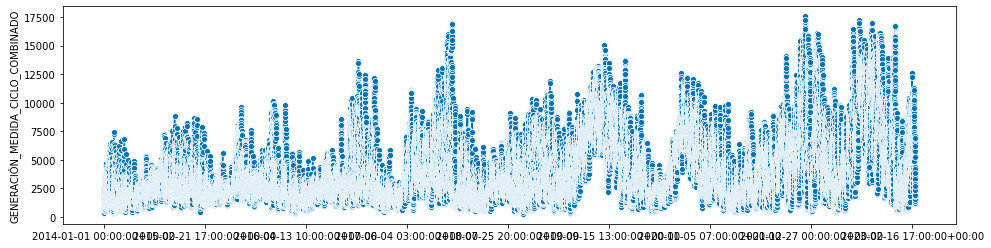

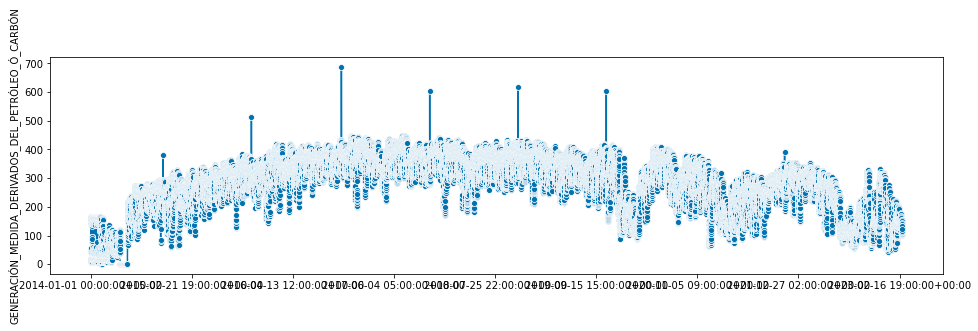

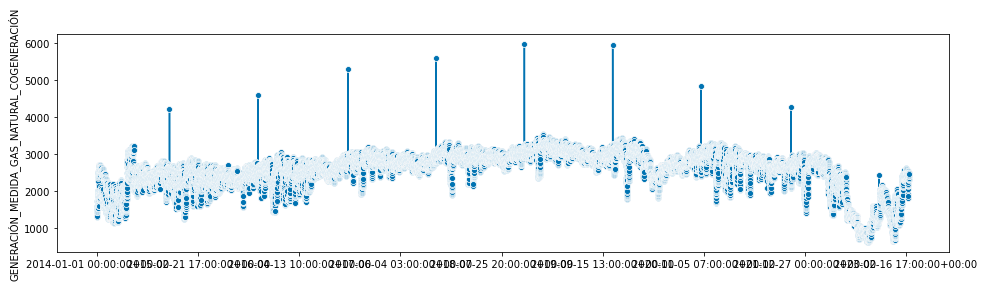

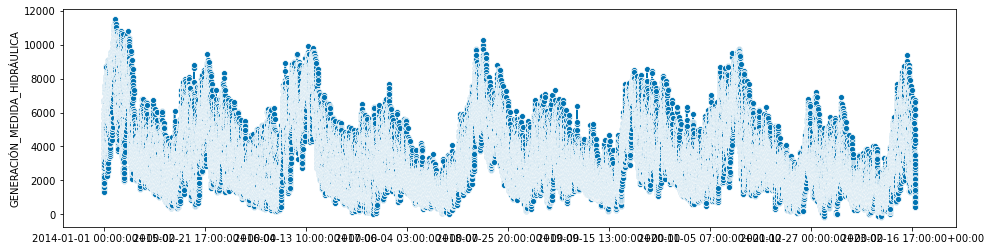

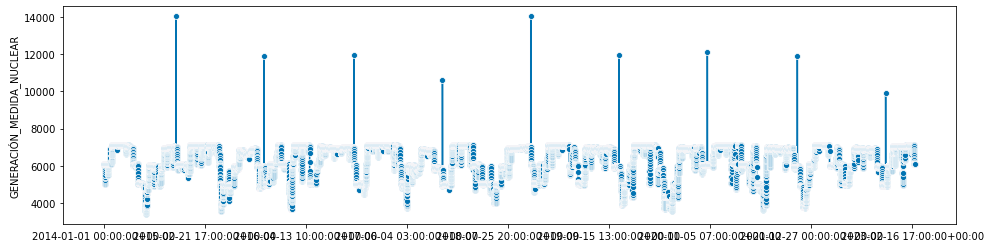

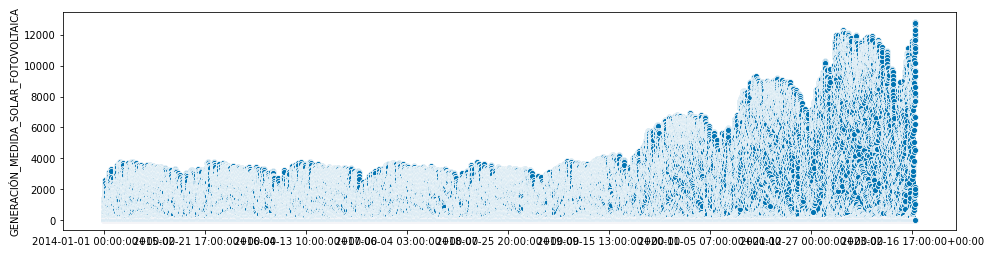

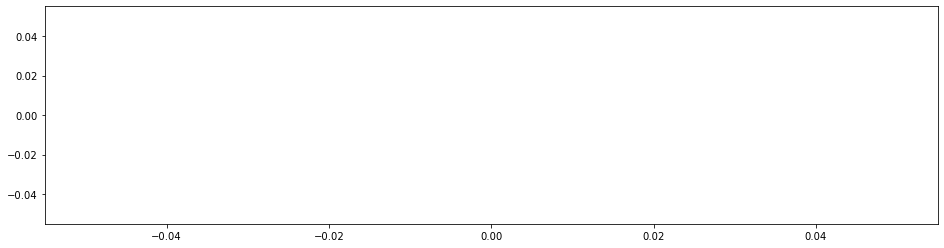

In [239]:
series_list = []
for i, ticker in enumerate(esios_tickers):
    series = esios_provider.get_series(ticker)
    series_list.append(series)
    plot_series(series)

### PRECIO_MERCADO_SPOT_DIARIO

Problems with PRECIO_MERCADO_SPOT_DIARIO, let's study it in-depth

In [181]:
data_price = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO")
data_price

DATE
2014-01-01 00:00:00+00:00     10.34
2014-01-01 01:00:00+00:00      5.35
2014-01-01 02:00:00+00:00      5.00
2014-01-01 03:00:00+00:00      0.50
2014-01-01 04:00:00+00:00      0.00
                              ...  
2023-02-28 19:00:00+00:00    176.17
2023-02-28 20:00:00+00:00    165.01
2023-02-28 21:00:00+00:00    158.41
2023-02-28 22:00:00+00:00    152.09
2023-02-28 23:00:00+00:00    145.00
Name: PRECIO_MERCADO_SPOT_DIARIO, Length: 80304, dtype: float64

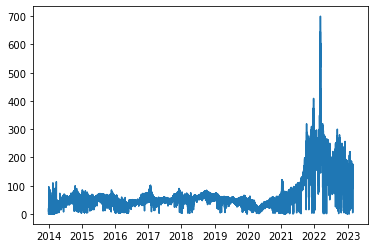

In [182]:
plt.plot(data_price)

In [207]:
duplicated_idx = np.where(data_price.index.duplicated(keep=False) == True)
data_price.iloc[duplicated_idx]

DATE
2014-10-26 00:00:00+00:00     42.32
2014-10-26 00:00:00+00:00     41.63
2015-10-25 00:00:00+00:00     38.13
2015-10-25 00:00:00+00:00     38.00
2016-10-30 00:00:00+00:00     49.75
2016-10-30 00:00:00+00:00     47.90
2017-10-29 00:00:00+00:00     41.15
2017-10-29 00:00:00+00:00     40.90
2018-10-28 00:00:00+00:00     52.40
2018-10-28 00:00:00+00:00     50.12
2019-10-27 00:00:00+00:00     42.81
2019-10-27 00:00:00+00:00     42.95
2020-10-25 00:00:00+00:00      1.95
2020-10-25 00:00:00+00:00      1.95
2021-10-31 00:00:00+00:00     74.78
2021-10-31 00:00:00+00:00     69.37
2022-10-30 00:00:00+00:00    100.25
2022-10-30 00:00:00+00:00    100.90
Name: PRECIO_MERCADO_SPOT_DIARIO, dtype: float64

Duplicated values for some dates due to the winter time change.

In [185]:
print(len(data_price))
print(data_price.index.min())
print(data_price.index.max())

80304
2014-01-01 00:00:00+00:00
2023-02-28 23:00:00+00:00


In [193]:
date_range_esios.difference(data_price.index)

DatetimeIndex(['2014-10-26 01:00:00+00:00', '2015-10-25 01:00:00+00:00',
               '2016-10-30 01:00:00+00:00', '2017-10-29 01:00:00+00:00',
               '2018-10-28 01:00:00+00:00', '2019-10-27 01:00:00+00:00',
               '2020-10-25 01:00:00+00:00', '2021-10-31 01:00:00+00:00',
               '2022-10-30 01:00:00+00:00'],
              dtype='datetime64[ns, tzutc()]', freq=None)

What is happening is that the value for 00:00 hours of those days is repeated twice, while there is no value for 01:00 hours. To solve this, we are modifying the second 00:00 value to 01:00.

In [234]:
data_price_clean = data_price

duplicated_index = data_price.index[data_price.index.duplicated(keep="first")]
new_index = duplicated_index + timedelta(hours=1)

updated_index = data_price_clean.index.copy()
idx = np.where(data_price.index.duplicated(keep="first") == True)
updated_index.values[idx] = new_index

data_price_clean.index = updated_index

In [233]:
date_range_esios.difference(data_price_clean.index)

DatetimeIndex([], dtype='datetime64[ns, tzutc()]', freq='H')

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='PRECIO_MERCADO_SPOT_DIARIO'>)

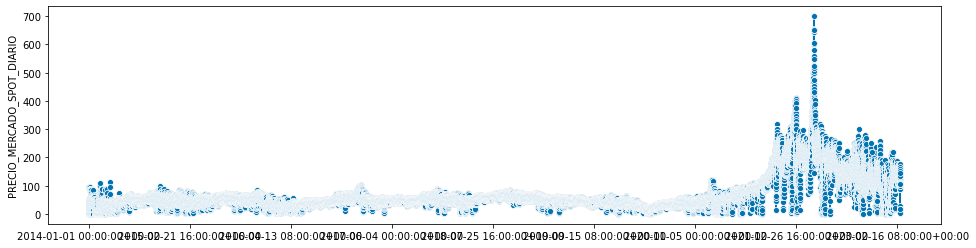

In [235]:
plot_series(data_price_clean)

Now it's repaired. Now we are looking for missing values.

In [238]:
data_price_clean.isna().sum()

0

No missing values for this time series

### Rest of time series

In [274]:
for ticker, series in zip(esios_tickers, series_list):
    print(ticker)
    print("Number of entries:", len(series))
    print("Number of repeated dates:", len(np.where(series.index.duplicated(keep="first")==True)[0]))
    print("Number of missing dates:", len(date_range_esios.difference(series.index)))
    print("Missing values:", series.isna().sum())
    print()

DEMANDA_REAL
Number of entries: 80304
Number of repeated dates: 0
Number of missing dates: 0
Missing values: 9

GENERACIÓN_MEDIDA_TOTAL
Number of entries: 80294
Number of repeated dates: 0
Number of missing dates: 10
Missing values: 0

GENERACIÓN_MEDIDA_EÓLICA_TERRESTRE
Number of entries: 80294
Number of repeated dates: 0
Number of missing dates: 10
Missing values: 0

GENERACIÓN_MEDIDA_CICLO_COMBINADO
Number of entries: 80294
Number of repeated dates: 0
Number of missing dates: 10
Missing values: 0

GENERACIÓN_MEDIDA_DERIVADOS_DEL_PETRÓLEO_Ó_CARBÓN
Number of entries: 80292
Number of repeated dates: 0
Number of missing dates: 12
Missing values: 0

GENERACIÓN_MEDIDA_GAS_NATURAL_COGENERACIÓN
Number of entries: 80294
Number of repeated dates: 0
Number of missing dates: 10
Missing values: 0

GENERACIÓN_MEDIDA_HIDRÁULICA
Number of entries: 80294
Number of repeated dates: 0
Number of missing dates: 10
Missing values: 0

GENERACIÓN_MEDIDA_NUCLEAR
Number of entries: 80294
Number of repeated dat

No missing values except for the first time series. In the rest of series there are missing dates. What is happening for the first time series is that, as we are aggregating 10 minute data into hours, there is one hour in which there are no data. And it appears as missing value, but is equivalent to missing date due to time change in Spain:

In [295]:
idx = np.where(series_list[0].isna()==True)
series_list[0].iloc[idx]

2014-10-26 01:00:00+00:00   NaN
2015-10-25 01:00:00+00:00   NaN
2016-10-30 01:00:00+00:00   NaN
2017-10-29 01:00:00+00:00   NaN
2018-10-28 01:00:00+00:00   NaN
2019-10-27 01:00:00+00:00   NaN
2020-10-25 01:00:00+00:00   NaN
2021-10-31 01:00:00+00:00   NaN
2022-10-30 01:00:00+00:00   NaN
Name: DEMANDA_REAL, dtype: float64

In [297]:
data_demand_clean = series_list[0].interpolate()
data_demand_clean.iloc[idx]

2014-10-26 01:00:00+00:00    18996.791667
2015-10-25 01:00:00+00:00    19844.708333
2016-10-30 01:00:00+00:00    19782.666667
2017-10-29 01:00:00+00:00    19857.250000
2018-10-28 01:00:00+00:00    19979.291667
2019-10-27 01:00:00+00:00    19892.625000
2020-10-25 01:00:00+00:00    19213.500000
2021-10-31 01:00:00+00:00    19784.125000
2022-10-30 01:00:00+00:00    18166.020833
Name: DEMANDA_REAL, dtype: float64

For the other variables there are no repeated dates, but still missing. We need to reindex them if we want to solve this problem. For example, for GENERACIÓN_MEDIDA_TOTAL:

In [285]:
total_generation_clean = series_list[1].reindex(date_range_esios)

In [286]:
total_generation_clean["2014-10-26 00:00:00+00:00"]

38502.343

In [287]:
total_generation_clean["2014-10-26 01:00:00+00:00"]

nan

In [288]:
total_generation_clean.interpolate(inplace=True)

In [291]:
total_generation_clean["2014-10-26 00:00:00+00:00"]

38502.343

In [289]:
total_generation_clean["2014-10-26 01:00:00+00:00"]

28568.3475

In [292]:
total_generation_clean["2014-10-26 02:00:00+00:00"]

18634.352

Everything that we have studied in this notebook will be used to improve ESIOS etl()